# Water Quality Prediction

Predicting if water safe to drink in stated water composition.

# Import Library

In [670]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import sys
import phik

#Disable Warning
import warnings
warnings.filterwarnings('ignore')

# Outlier Handling
from feature_engine.outliers import Winsorizer

# Balancing Data
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer

# Machine Learning Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Evaluation
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Data Loading

In [671]:
database = pd.read_csv('waterQuality1.csv')
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [672]:
database.replace('#NUM!',0,inplace= True)

In [673]:
database['ammonia'] = database['ammonia'].astype(float)
database['is_safe'] = database['is_safe'].astype(int)
database.to_csv('waterQuality1.csv',index=False)
database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   float64
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [674]:
database.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [675]:
database.tail()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
7994,0.05,7.78,0.00,1.95,0.04,0.10,0.03,0.03,1.37,0.0,...,0.197,14.29,1.0,0.005,3.57,2.13,0.09,0.06,0.03,1
7995,0.05,24.22,0.02,0.59,0.01,0.45,0.02,0.02,1.48,0.0,...,0.031,10.27,1.0,0.001,1.48,1.11,0.09,0.10,0.08,1
7996,0.09,6.85,0.00,0.61,0.03,0.05,0.05,0.02,0.91,0.0,...,0.182,15.92,1.0,0.000,1.35,4.84,0.00,0.04,0.05,1
7997,0.01,10.00,0.01,2.00,0.00,2.00,0.00,0.09,0.00,0.0,...,0.000,0.00,0.0,0.000,0.00,0.00,0.00,0.00,0.00,1
7998,0.04,6.85,0.01,0.70,0.03,0.05,0.01,0.03,1.00,0.0,...,0.182,15.92,1.0,0.000,1.35,4.84,0.00,0.04,0.05,1


Insight: Data Has 20 column with 20 numeric type.

# Exploration Data Analysis

### See Value Counts of Target

In [676]:
database['is_safe'].value_counts()

is_safe
0    7087
1     912
Name: count, dtype: int64

<Axes: ylabel='is_safe'>

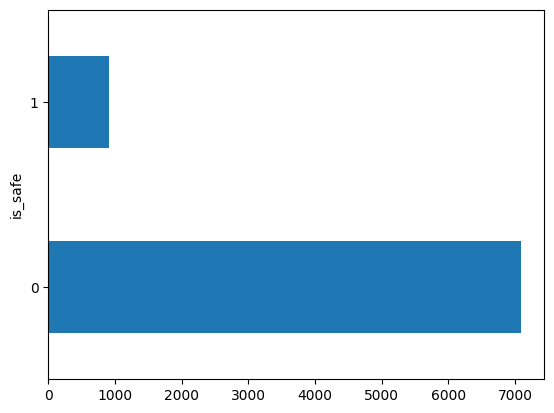

In [677]:
database['is_safe'].value_counts().plot.barh()

Insight: Data are imbalance

### See mean of viruses based on target

<Axes: ylabel='is_safe'>

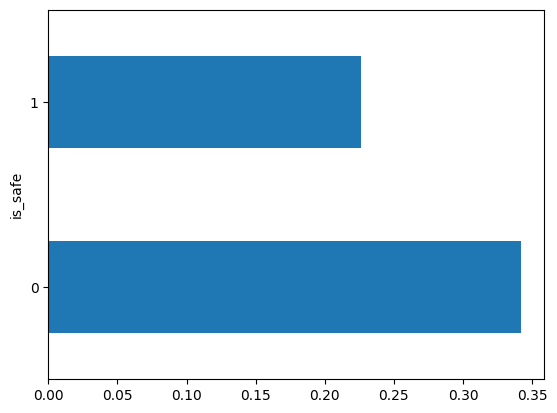

In [678]:
database.groupby('is_safe')['viruses'].mean().plot.barh()

Insight: There more viruses on not safe water

### See mean of aluminium based on target

<Axes: ylabel='is_safe'>

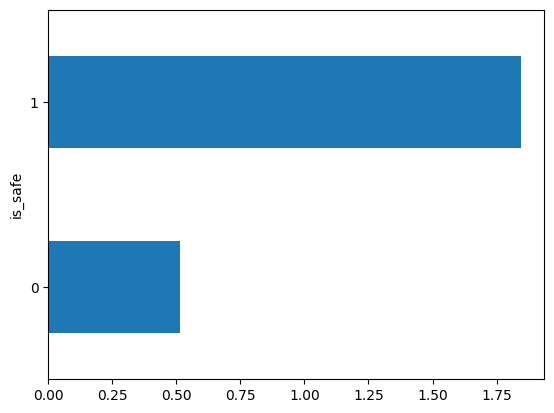

In [679]:
database.groupby('is_safe')['aluminium'].mean().plot.barh()

Insight: Aluminium composition are higher on safe water than unsafe water.

### See mean of ammonia based on target

<Axes: ylabel='is_safe'>

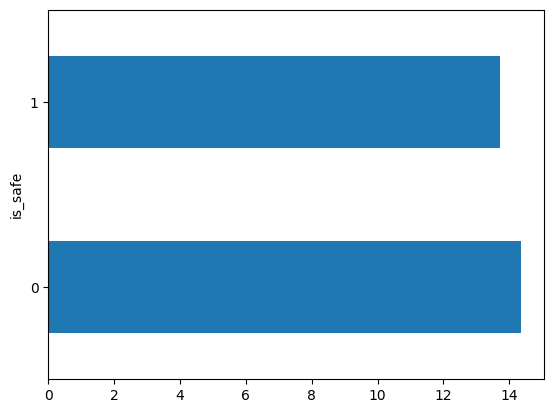

In [680]:
database.groupby('is_safe')['ammonia'].mean().plot.barh()

Insight: Ammonia composition are higher on unsafe water than safe water.

### See mean of flouride based on target

<Axes: ylabel='is_safe'>

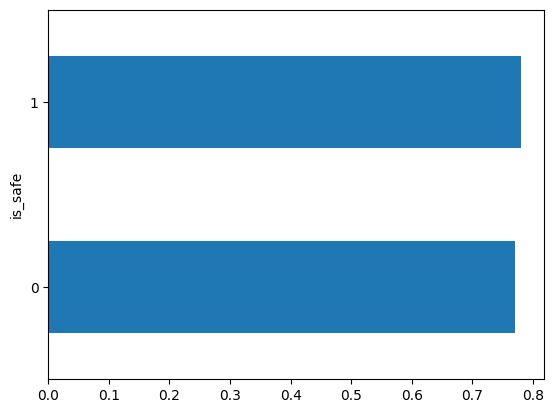

In [681]:
database.groupby('is_safe')['flouride'].mean().plot.barh()

Insight: Flouride composition are higher on safe water than unsafe water.

### See Cardinality of Data

In [682]:
database.nunique()

aluminium       495
ammonia        2563
arsenic         107
barium          480
cadmium          23
chloramine      812
chromium         91
copper          201
flouride        151
bacteria        101
viruses          61
lead            200
nitrates       1803
nitrites        280
mercury          11
perchlorate    2999
radium          735
selenium         11
silver           51
uranium          10
is_safe           2
dtype: int64

<Axes: >

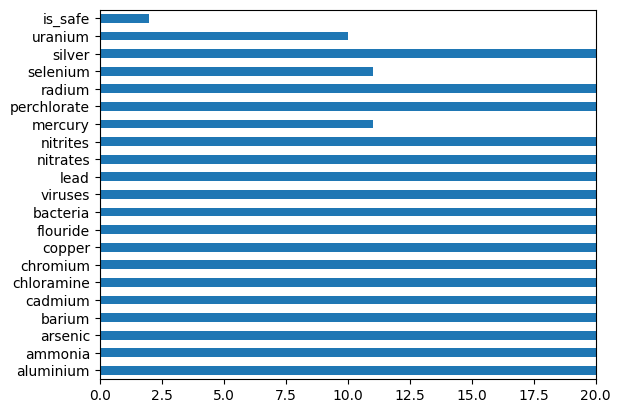

In [683]:
# Visualization
database.nunique().plot.barh(xlim=[0,20])

Insight: All columns except is_safe, uranium, selenium, and mercury has large unique data with cardinality > 15

### See the Means Of Data

In [684]:
database.describe().T['mean']

aluminium       0.666158
ammonia        14.272857
arsenic         0.161445
barium          1.567715
cadmium         0.042806
chloramine      2.176831
chromium        0.247226
copper          0.805857
flouride        0.771565
bacteria        0.319665
viruses         0.328583
lead            0.099450
nitrates        9.818822
nitrites        1.329961
mercury         0.005194
perchlorate    16.460299
radium          2.920548
selenium        0.049685
silver          0.147781
uranium         0.044673
is_safe         0.114014
Name: mean, dtype: float64

<Axes: >

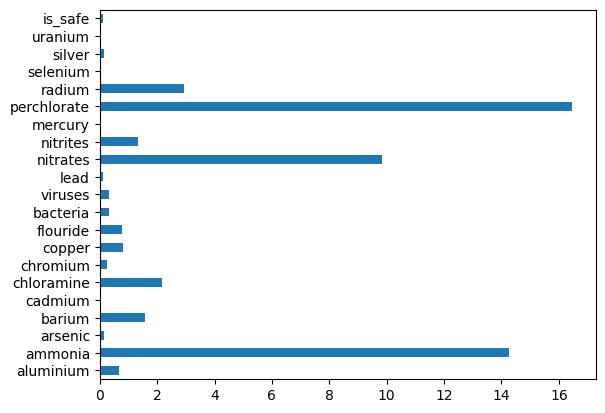

In [685]:
#Visualization
database.describe().loc['mean'].plot(kind='barh')

Insight: perchlorate column are column that has highest mean value

### See Skewness of Data

In [686]:
database.select_dtypes(include=np.number).skew()

aluminium      2.014072
ammonia        0.027021
arsenic        1.985851
barium         0.661337
cadmium        0.477800
chloramine     0.888680
chromium       1.028728
copper         0.253732
flouride      -0.039305
bacteria       0.554535
viruses        0.425198
lead          -0.060862
nitrates      -0.041938
nitrites      -0.498531
mercury       -0.082363
perchlorate    0.938290
radium         0.548553
selenium       0.010362
silver         1.030034
uranium       -0.027111
is_safe        2.429348
dtype: float64

<Axes: >

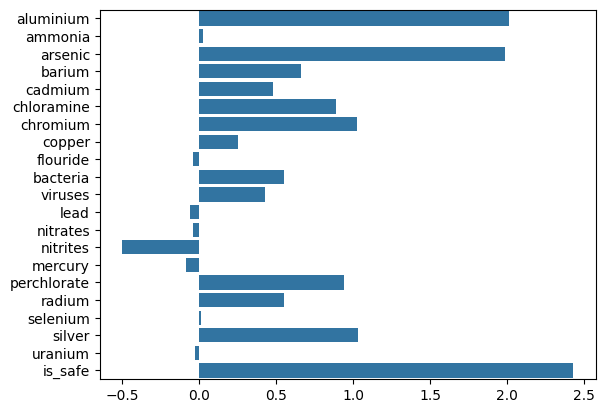

In [687]:
# Visualization
sns.barplot(database.select_dtypes(include=np.number).skew(),orient='h')

Insight: ammonia, viruses, lead, nitrates, mercury, selenium and uranium has Normal Distribution of Data, while other than that has Skewwed Distribution of Data.

### See Kurtosis of Data

In [688]:
database.select_dtypes(include=np.number).kurtosis()

aluminium      2.725696
ammonia       -1.229115
arsenic        2.687495
barium        -0.703076
cadmium       -0.992416
chloramine    -0.681145
chromium      -0.371716
copper        -1.353599
flouride      -1.173014
bacteria      -1.140151
viruses       -1.590417
lead          -1.154845
nitrates      -1.188328
nitrites      -0.358137
mercury       -1.171019
perchlorate   -0.494062
radium        -0.924825
selenium      -1.099183
silver        -0.291147
uranium       -1.170478
is_safe        3.902709
dtype: float64

<Axes: >

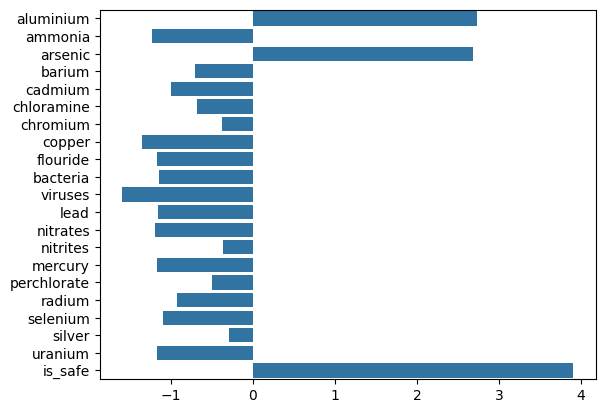

In [689]:
# Visualization
sns.barplot(database.select_dtypes(include=np.number).kurtosis(),orient='h')

Insight: Majority of data has outlier with kurtosis not equal to 0.

### See Correlation of Each Data

<Axes: >

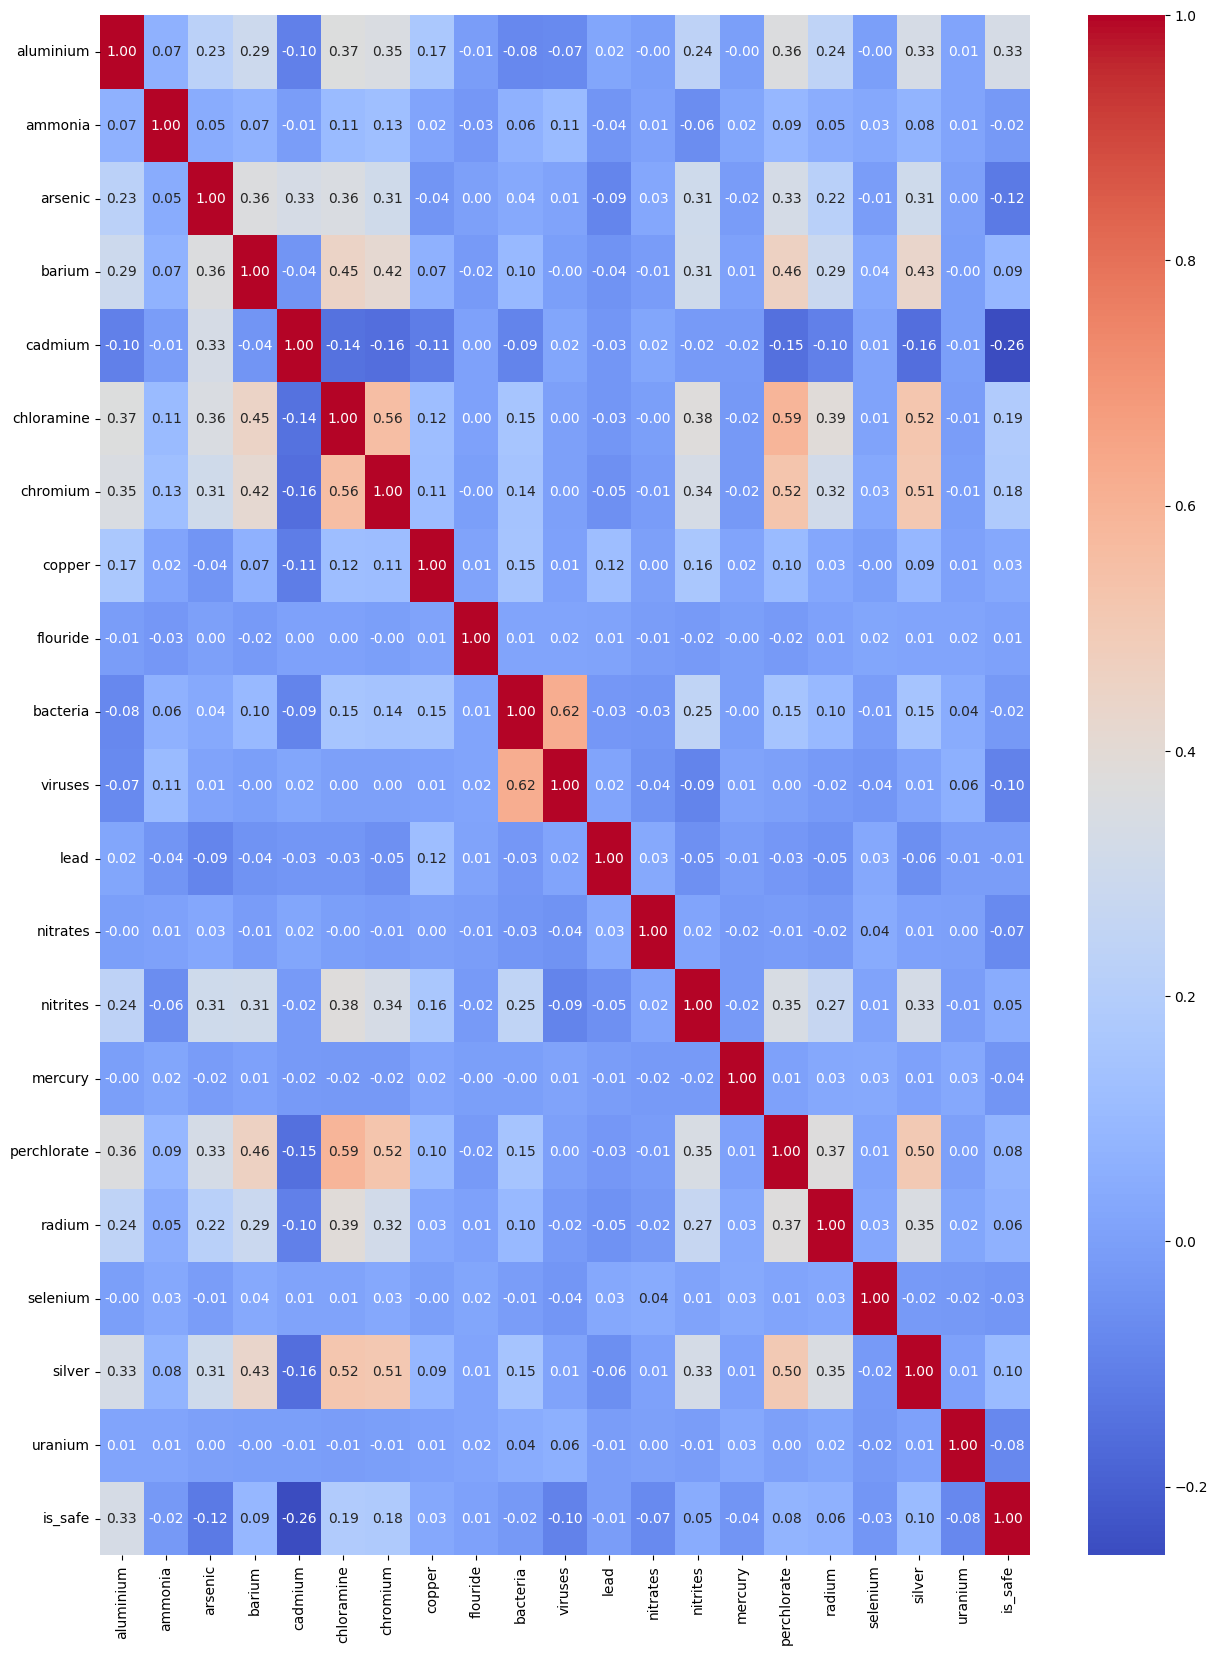

In [690]:
plt.figure(figsize=(15,20))
sns.heatmap(database.corr(),annot=True,fmt='.2f',cmap='coolwarm')

Insight: 'aluminium', 'arsenic', 'cadmium', 'chloramine', 'chromium', 'silver' are column that have high correlation towards data with correlation > 10%.

In [691]:
feature = database.corr().query('is_safe > 0.1 or is_safe < -0.1').index[:-1].tolist()

### See Correlation of Each Feature

<Axes: >

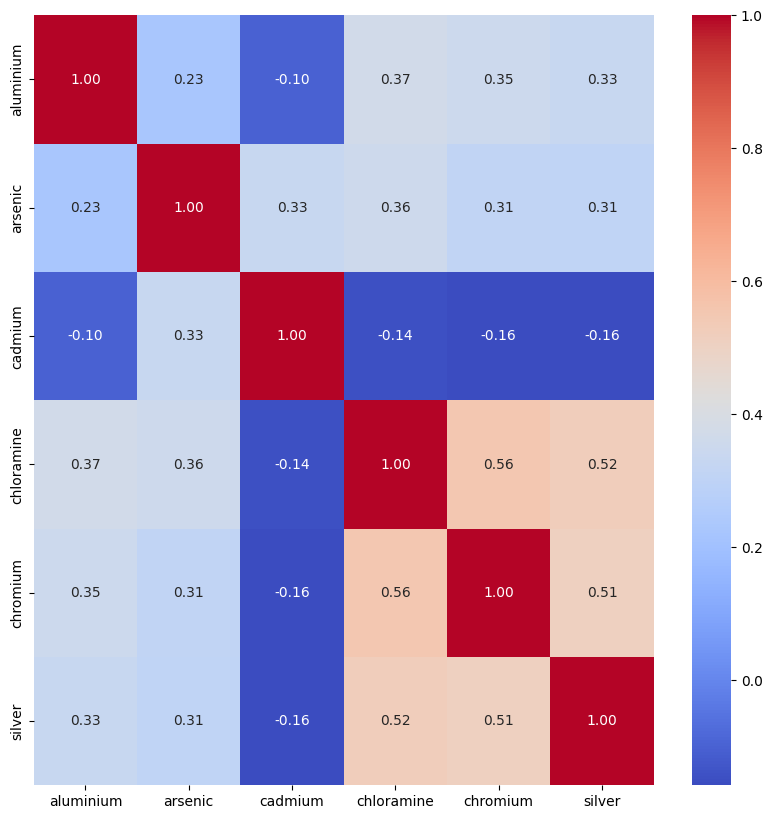

In [692]:
plt.figure(figsize=(10,10))
sns.heatmap(database[feature].corr(),annot=True,fmt='.2f',cmap='coolwarm')

All feature are correlated to each other

### See Correlation From Feature to Target

<Axes: >

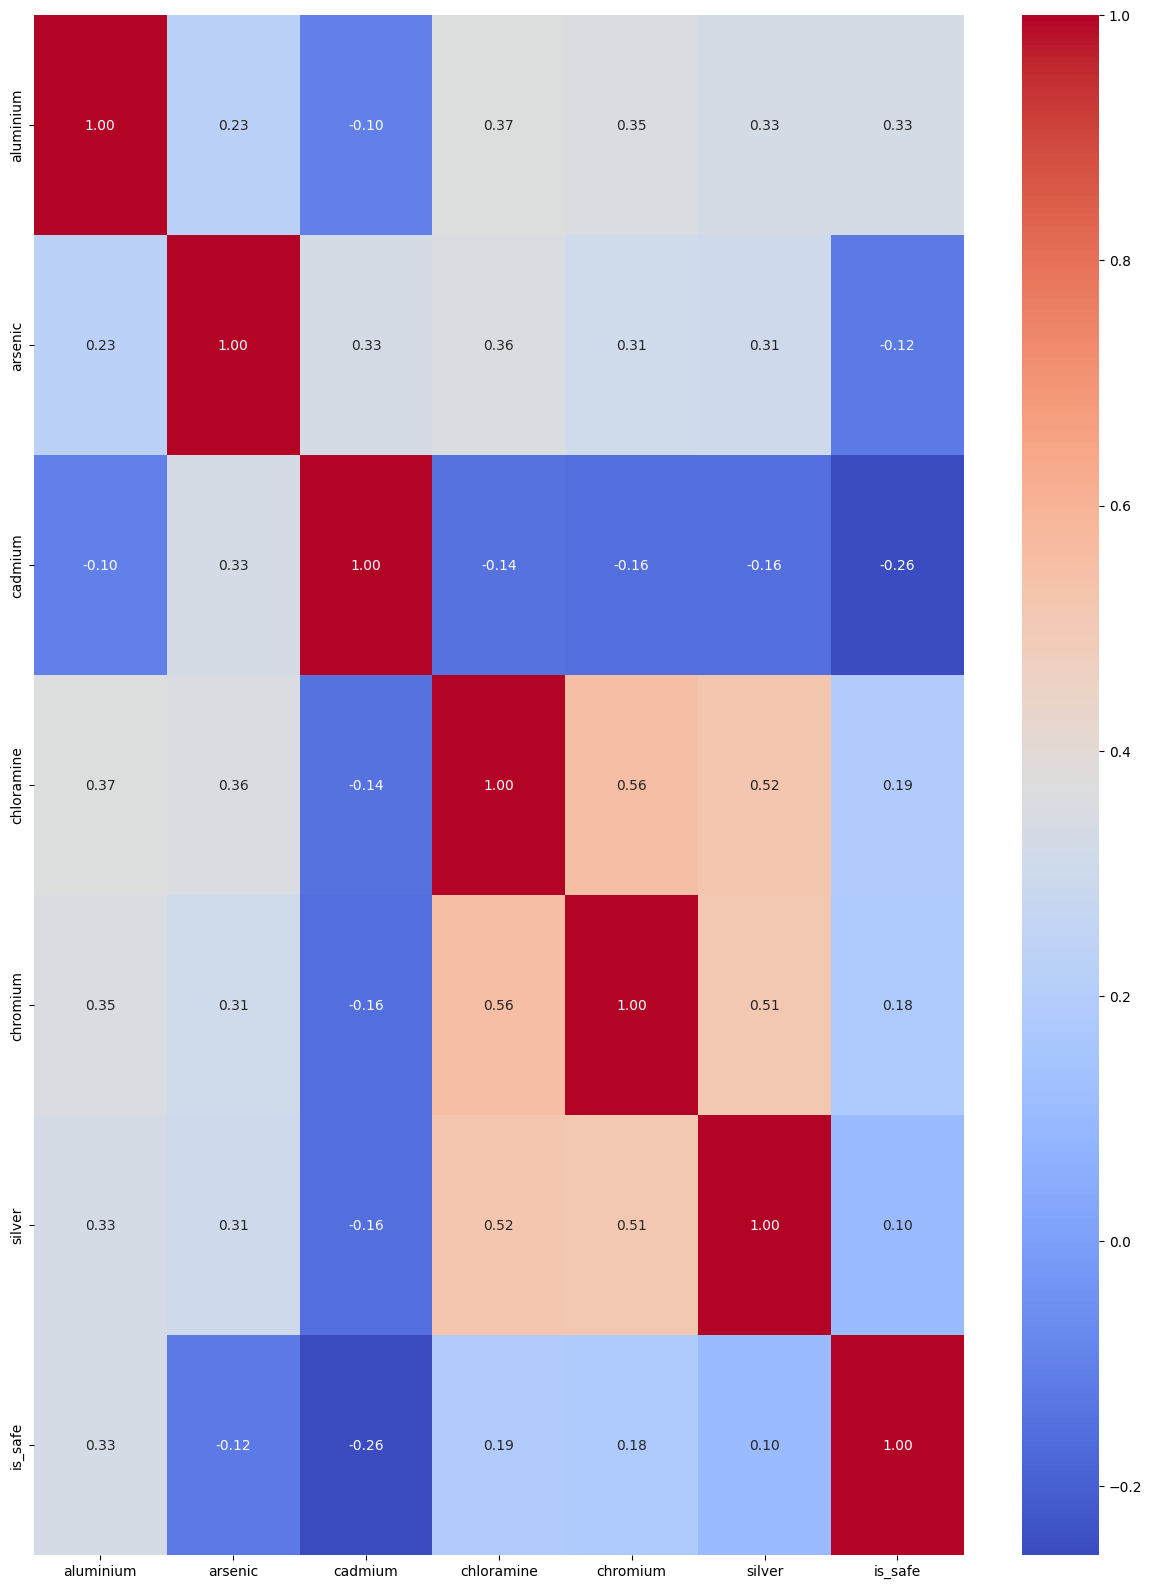

In [693]:
plt.figure(figsize=(15,20))
sns.heatmap(database[feature+[database.columns[-1]]].corr(),annot=True,fmt='.2f',cmap='coolwarm')

Insight: arsenic and cadmium has negative correlation while alluminium, chloramine, chromium and silver has positive correlation

### See Skewness of Feature

In [694]:
database[feature].select_dtypes(include=np.number).skew()

aluminium     2.014072
arsenic       1.985851
cadmium       0.477800
chloramine    0.888680
chromium      1.028728
silver        1.030034
dtype: float64

<Axes: >

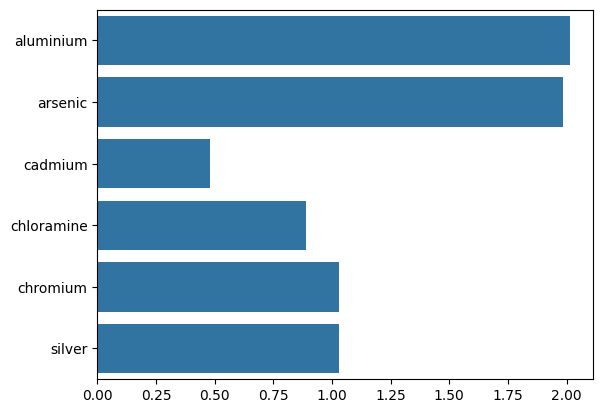

In [695]:
# Visualization
sns.barplot(database[feature].select_dtypes(include=np.number).skew(),orient='h')

Insight: Feature has Skewwed distribution with skewness > 0.5 except cadmium.

### See Kurtosis of Feature

In [696]:
database[feature].select_dtypes(include=np.number).kurtosis()

aluminium     2.725696
arsenic       2.687495
cadmium      -0.992416
chloramine   -0.681145
chromium     -0.371716
silver       -0.291147
dtype: float64

<Axes: >

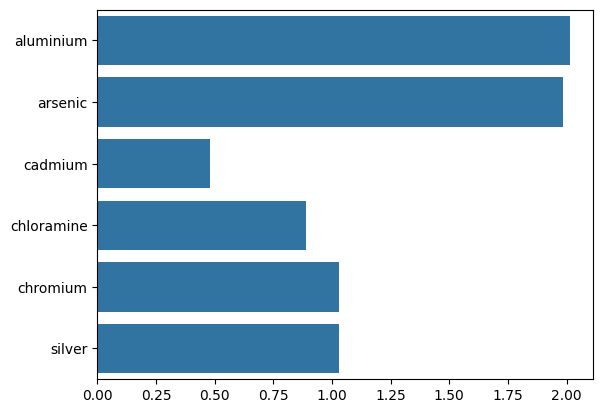

In [697]:
#Visualization
sns.barplot(database[feature].select_dtypes(include=np.number).skew(),orient='h')

Insight: aluminium and arseninc has large outlier with kurtosis >= 1

### See Cardinality of Feature

In [698]:
database[feature].nunique()

aluminium     495
arsenic       107
cadmium        23
chloramine    812
chromium       91
silver         51
dtype: int64

<Axes: >

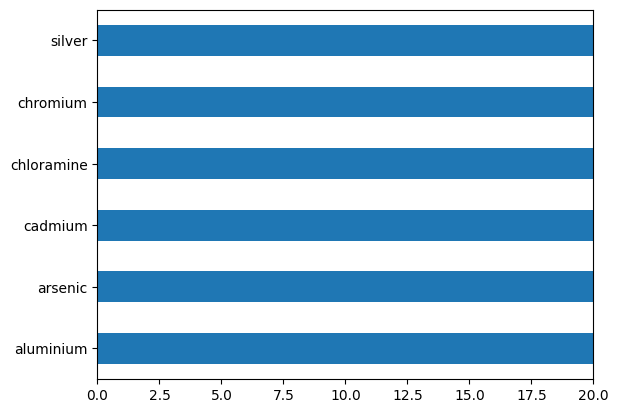

In [699]:
#Visualization
database[feature].nunique().plot.barh(xlim=[0,20])

Insight: Feature have High Cardinality, meaning Feature are Numeric Data

## EDA Conclusion
- All Data has high cardinality except is_safe, **So is_safe are categorical and outlier doesn't need to be handled**
- All Data have number type, **so all feature will be scalled**
- The feature are **'aluminium', 'arsenic', 'cadmium', 'chloramine', 'chromium', 'silver'** columns
- The target are **is_safe** column
- Feature Have High Cardinality, **so feature are numeric**
- Some Feature has Large Outlier, **so outlier need to be handled** 
- Some Feature has skewwed Data, **So Scaling technique that be used are RobustScaler and Outlier Handling that'll be used are IQR capping method and gaussian method**
- There's no Empty Data

# Feature Engineering

### Data Splitting

In [700]:
X,y = database.drop(columns=[database.columns[-1]]), database[database.columns[-1]]
[X.shape, y.shape]

[(7999, 20), (7999,)]

Insight: Data Has Been Splitted with X as feature and y as Target.

### Feature Selection

Based on EDA, feature has been selected and stored on feature variable.

In [701]:
X=X[feature]
X.columns

Index(['aluminium', 'arsenic', 'cadmium', 'chloramine', 'chromium', 'silver'], dtype='object')

### Train Test Split

In [702]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=0,stratify=y)

Insight: Data Has been splitted to train and test

### Handling Outlier

In [703]:
# Handling Outlier
num = [i for i in X.select_dtypes(include=np.number).columns if X[i].nunique()>15]
normal = [i for i in num if abs(X[i].skew())<0.5]
skew = [i for i in num if abs(X[i].skew())>0.5]

win_norm = Winsorizer(capping_method='iqr',fold=1.5,tail='both',variables=normal)
win_skew = Winsorizer(capping_method='iqr',fold=1.5,tail='both',variables=skew)

win_norm.fit(X_train[normal])
win_skew.fit(X_train[skew])

X_train[normal] = win_norm.transform(X_train[normal]).values
X_train[skew] = win_skew.transform(X_train[skew])
X_test[normal] = win_norm.transform(X_test[normal]).values
X_test[skew] = win_skew.transform(X_test[skew])

Insight: Outlier has been handled

### Balancing Data

In [704]:
#Balancing Data
smote = SMOTE()
X_train,y_train = smote.fit_resample(X_train,y_train)
X_test,y_test = smote.fit_resample(X_test,y_test)

# Model Definition

In [705]:
# Model Definition
model_base = {
    'logic':LogisticRegression(),    
    'knn':KNeighborsClassifier(),
    'svc':SVC(),
    'decision':DecisionTreeClassifier(),
    'random':RandomForestClassifier(),
    'boost':GradientBoostingClassifier()
}
model={}
for key,modeling in model_base.items():
    model[key]=Pipeline([('imputter',SimpleImputer(strategy='constant',fill_value=0)),('scaler',RobustScaler()),('model',modeling)])
model

{'logic': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()), ('model', LogisticRegression())]),
 'knn': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()), ('model', KNeighborsClassifier())]),
 'svc': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()), ('model', SVC())]),
 'decision': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', DecisionTreeClassifier())]),
 'random': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', RandomForestClassifier())]),
 'boost': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', Rob

Insight: Model Has Been Defined

In [706]:
# Hyperparameter definition
hyperparam = {
    'logic': {
        'model__C': [0.01, 0.1, 1.0],
        'model__solver': ['liblinear', 'lbfgs', 'sag','newton-cg'],
        'model__max_iter': [100, 200]
    },
    'knn': {
        'model__n_neighbors': [3, 5, 7, 9, 11],
        'model__p': [1, 2],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree']
    },
    'svc': {
        'model__C': [0.01, 0.1, 1.0],
        'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    },
    'decision':{
        'model__criterion': ['gini', 'entropy'],
        'model__splitter': ['best', 'random'],
        'model__max_depth': [None, 10, 20, 30],  # Adjust based on your dataset and complexity requirements
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', None]
    },
    'random': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]},
    'boost': {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]}
}

Insight: Hyperparameter Has Been Defined

# Model Training

In [707]:
### Without Tunning
wot_model = {}
for key, modeling in model.items():
    wot_model[key] = modeling.fit(X_train,y_train)
wot_model

{'logic': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()), ('model', LogisticRegression())]),
 'knn': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()), ('model', KNeighborsClassifier())]),
 'svc': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()), ('model', SVC())]),
 'decision': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', DecisionTreeClassifier())]),
 'random': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', RandomForestClassifier())]),
 'boost': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', Rob

Insight: Model Has Been Train without tunning.

# Cross-Validation Check

In [708]:
train = {}
for key,modeling in model.items():
    cv = cross_val_score(modeling,X_train,y_train,cv=5)
    train[key]={
        'All - Cross Validation':[round(i,2) for i in cv],
        'Mean - Cross Validation Score':round(cv.mean(),2),
        'Standard Deviation - Cross-Validation Score':round(cv.std(),2),
        'Range of Test-Set ':f'{abs(round(round(cv.mean()-cv.std(),2)-round(cv.mean()+cv.std(),2),2))}'
        }

pd.DataFrame(train).T.sort_values(by=['Mean - Cross Validation Score','Standard Deviation - Cross-Validation Score'])

,All - Cross Validation,Mean - Cross Validation Score,Standard Deviation - Cross-Validation Score,Range of Test-Set
logic,"[0.81, 0.82, 0.82, 0.81, 0.82]",0.82,0.01,0.01
svc,"[0.84, 0.87, 0.87, 0.86, 0.87]",0.86,0.01,0.02
knn,"[0.87, 0.88, 0.88, 0.87, 0.88]",0.88,0.01,0.01
decision,"[0.82, 0.93, 0.91, 0.93, 0.94]",0.91,0.04,0.09
boost,"[0.84, 0.94, 0.94, 0.94, 0.95]",0.92,0.04,0.08
random,"[0.86, 0.95, 0.96, 0.95, 0.96]",0.94,0.04,0.08


Logistic Regression will be tunned because it has lower Mean-CV score and Standard Deviation-CV score.

## Model Optimization

Precision Score will be focused because the prediction need to avoid False Positive( Predicted safe but actually it's not) as low as possible.

In [709]:
### With Tunning
logic_hyperparam = {
    'liblinear':{
        'model__C': [0.01, 0.1, 1.0],
        'model__solver': ['liblinear'],
        'model__max_iter': [100, 200],
        'model__penalty':['l1','l2']
        },
    'lbfgs':{
        'model__C': [0.01, 0.1, 1.0],
        'model__solver': ['lbfgs'],
        'model__max_iter': [100, 200],
        'model__penalty':[None,'l2']
        },
    'newton-cg':{
        'model__C': [0.01, 0.1, 1.0],
        'model__solver': ['newton-cg'],
        'model__max_iter': [100, 200],
        'model__penalty':[None,'l2']
        },
    'newton-cholesky':{
        'model__C': [0.01, 0.1, 1.0],
        'model__solver': ['newton-cholesky'],
        'model__max_iter': [100, 200],
        'model__penalty':[None,'l2']
        },
    'sag':{
        'model__C': [0.01, 0.1, 1.0],
        'model__solver': ['sag'],
        'model__max_iter': [100, 200],
        'model__penalty':[None,'l2']
        },
    'saga':{
        'model__C': [0.01, 0.1, 1.0],
        'model__solver': ['saga'],
        'model__max_iter': [100, 200],
        'model__penalty':[None,'l2','l1','elasticnet']
        }
    
}
wt_model = {}
best_model = model['logic']
for key, param in logic_hyperparam.items():
    print(key)
    grid = GridSearchCV(best_model,logic_hyperparam[key],cv=5,n_jobs=-1,scoring='precision')
    grid.fit(X_train,y_train)
    wt_model[key] = grid.best_estimator_
wt_model

liblinear
lbfgs
newton-cg
newton-cholesky
sag
saga


{'liblinear': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model',
                  LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))]),
 'lbfgs': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', LogisticRegression(C=0.01, penalty=None))]),
 'newton-cg': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model',
                  LogisticRegression(C=0.01, penalty=None, solver='newton-cg'))]),
 'newton-cholesky': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model',
                  LogisticRegression(C=0.01, penalty=None,
                                     solver='newton-cholesky'))])

Insight: Model Has Been Trained with tunning

In [710]:
{'model':[i for key,i in wt_model.items()]}

{'model': [Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                  ('scaler', RobustScaler()),
                  ('model',
                   LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))]),
  Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                  ('scaler', RobustScaler()),
                  ('model', LogisticRegression(C=0.01, penalty=None))]),
  Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                  ('scaler', RobustScaler()),
                  ('model',
                   LogisticRegression(C=0.01, penalty=None, solver='newton-cg'))]),
  Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                  ('scaler', RobustScaler()),
                  ('model',
                   LogisticRegression(C=0.01, penalty=None,
                                      solver='newton-cholesky'))]),
  Pipeline(steps=[('imputte

In [711]:
test={'model':[i.named_steps['model'] for key,i in wt_model.items()]}
grid = GridSearchCV(model['logic'],test,cv=5,n_jobs=-1,scoring='precision')
grid.fit(X_train,y_train)
final_model = grid.best_estimator_
final_model

Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                ('scaler', RobustScaler()),
                ('model',
                 LogisticRegression(C=0.01, penalty='l1', solver='saga'))])

Best Model being saved on final model

### Tunning other model

To avoid bias over single model based on Cross Validation Score, other model will be tunned for comparison

In [712]:
### With Tunning
wt_model = {}
for key, param in model.items():
    if key == 'logic':
        continue
    print(key)
    grid = GridSearchCV(param,hyperparam[key],cv=5,n_jobs=-1,scoring='precision')
    grid.fit(X_train,y_train)
    wt_model[key] = grid.best_estimator_
wt_model

knn
svc
decision
random
boost


{'knn': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', KNeighborsClassifier(n_neighbors=11, p=1))]),
 'svc': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', SVC(C=0.01, kernel='linear'))]),
 'decision': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model',
                  DecisionTreeClassifier(max_depth=20, min_samples_leaf=2))]),
 'random': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', RandomForestClassifier(n_estimators=200))]),
 'boost': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
              

Other model has been tunned

### Get best model with GridSearchCV

In [713]:
test={'model':[i.named_steps['model'] for key,i in wt_model.items()]+[final_model]}
grid = GridSearchCV(model['logic'],test,cv=5,n_jobs=-1,scoring='precision')
grid.fit(X_train,y_train)
finale_model = grid.best_estimator_
finale_model

Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                ('scaler', RobustScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.2,
                                            n_estimators=200))])

Best Model are KNN with n_neigbors = 3 and p=1. But to make sure, I'll use entire model

In [714]:
wt_model['logic'] = test['model'][-1]
wt_model

{'knn': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', KNeighborsClassifier(n_neighbors=11, p=1))]),
 'svc': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', SVC(C=0.01, kernel='linear'))]),
 'decision': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model',
                  DecisionTreeClassifier(max_depth=20, min_samples_leaf=2))]),
 'random': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
                 ('model', RandomForestClassifier(n_estimators=200))]),
 'boost': Pipeline(steps=[('imputter', SimpleImputer(fill_value=0, strategy='constant')),
                 ('scaler', RobustScaler()),
              

# Model Evaluation

In [715]:
def right_percent(feature,target,model_train):
    result={}

    if isinstance(model_train, dict) and len(model_train)>1:
        for key,modeling in model_train.items():
            predict = modeling.predict(feature)
            result[key] = f'{round((target == predict).mean()*100,2)}%'
            print(f'{key} : {result[key]}')
    else:
        predict = model_train.predict(feature)
        result = f'{round((target == predict).mean()*100,2)}%'
        print(f'model: {result}')
    return result    

def full_eva(feature,target,model_train):
    if isinstance(model_train, dict) and len(model_train)>1:
        for key, modeling in model_train.items():
            predict = modeling.predict(feature)
            print("="*20,key,"="*20)
            print(classification_report(target,predict))
    else:
        predict = model_train.predict(feature)
        print(classification_report(target,predict))

def conf_matrix_show(feature,target,model_train):
    if isinstance(model_train, dict) and len(model_train)>1:
        for key, modeling in model_train.items():
            prediction = modeling.predict(feature)
            cm = confusion_matrix(target,prediction)
            disp = ConfusionMatrixDisplay(cm)
            disp.plot()
            plt.title(key)
            plt.show()
    else:
        prediction = model_train.predict(feature)
        cm = confusion_matrix(target,prediction)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.show()

### Match Percentage

In [716]:
print('='*20,'Train','='*20)
right_percent(X_train,y_train,wt_model)
print('='*20,'Test','='*20)
right_percent(X_test,y_test,wt_model)
# print('='*20,'Real Data Test','='*20)
# right_percent(X,y,wt_model)

==================== Train ====================
knn : 90.93%
svc : 81.95%
decision : 98.12%
random : 100.0%
boost : 96.87%
logic : 81.5%
==================== Test ====================
knn : 85.2%
svc : 83.47%
decision : 84.59%
random : 87.57%
boost : 93.79%
logic : 83.46%


{'knn': '85.2%',
 'svc': '83.47%',
 'decision': '84.59%',
 'random': '87.57%',
 'boost': '93.79%',
 'logic': '83.46%'}

Insight: 
- All model have high percentage
- Highest and Consistent percentage on train and test are Gradient Boosting Classifier model with match percentage >90% on train and test

### Classification Report

In [717]:
print('='*20,'Train','='*20,'\n'*5)

full_eva(X_train,y_train,wt_model)
print('\n'*5,'='*20,'Test','='*20,'\n'*5)
full_eva(X_test,y_test,wt_model)

==================== Train ==================== 





==================== knn ====================
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      4252
           1       0.90      0.92      0.91      4252

    accuracy                           0.91      8504
   macro avg       0.91      0.91      0.91      8504
weighted avg       0.91      0.91      0.91      8504

==================== svc ====================
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      4252
           1       0.91      0.71      0.80      4252

    accuracy                           0.82      8504
   macro avg       0.84      0.82      0.82      8504
weighted avg       0.84      0.82      0.82      8504

==================== decision ====================
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4252
           1       0.99      0.97      0

Insight: Gradient Boosting has highest recall score with recall score ~90%. Decision Tree and Random Forest are overfitting because perfect score on train but ~80% score on test.

### Confusion Matrix

==================== Train ====================


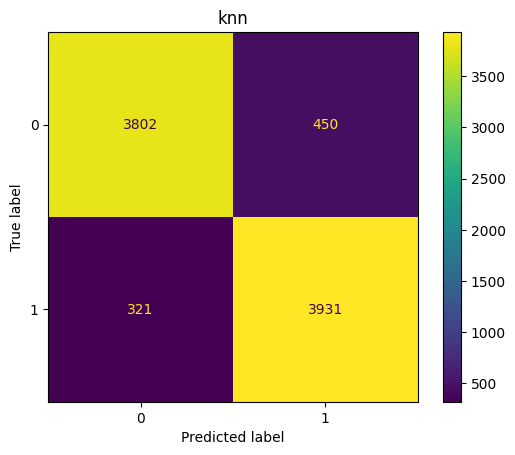

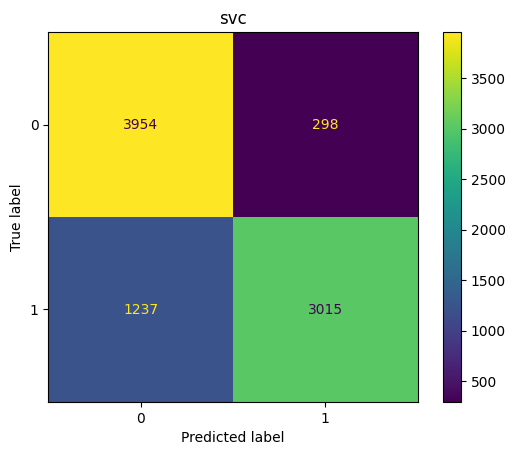

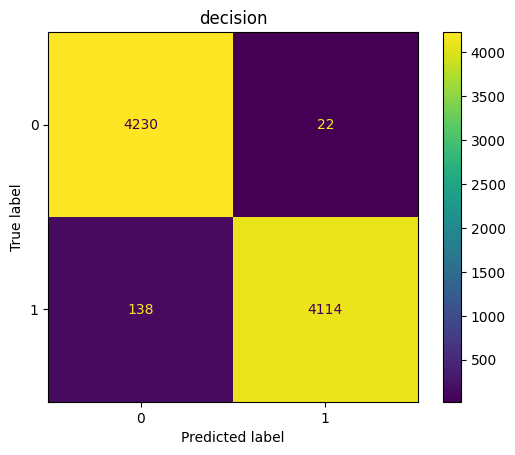

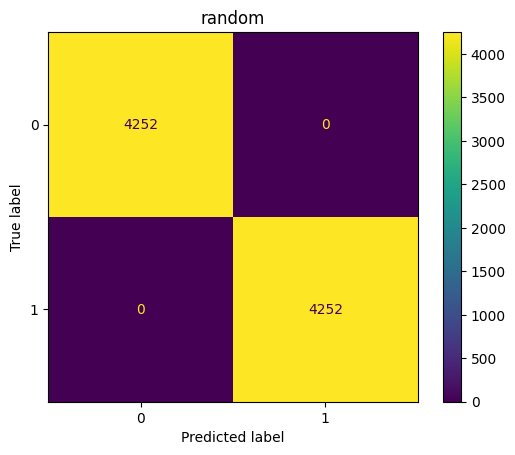

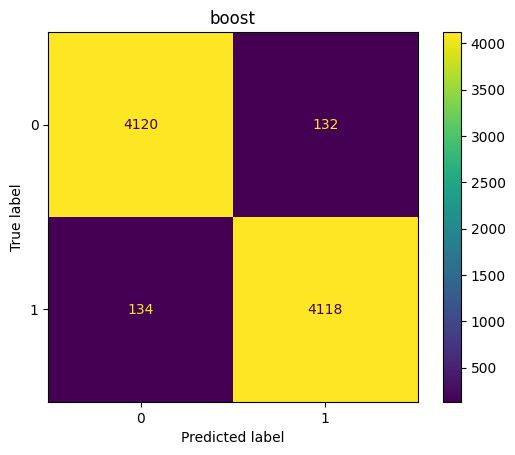

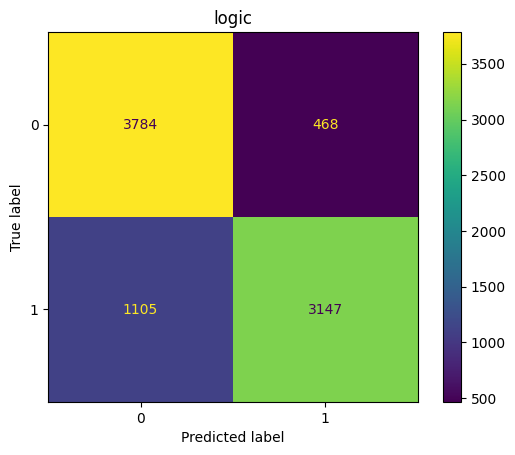

==================== Test ====================


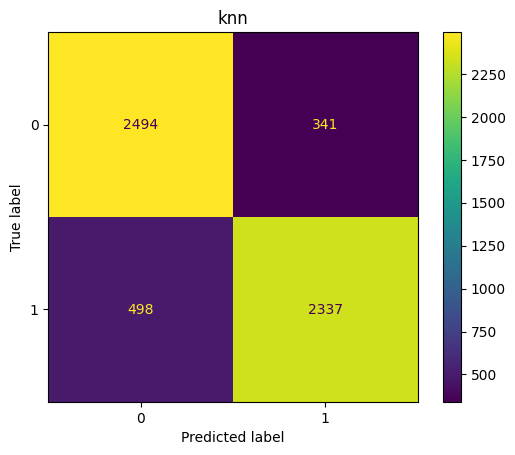

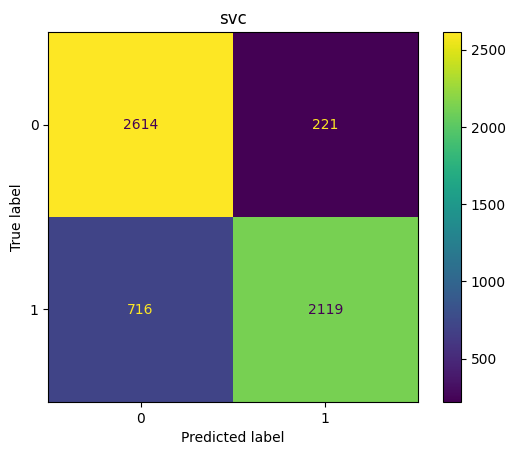

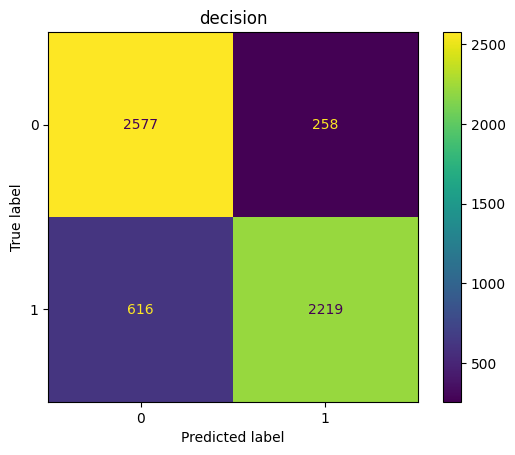

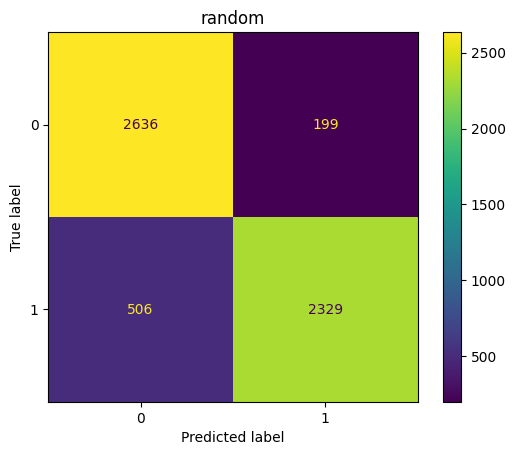

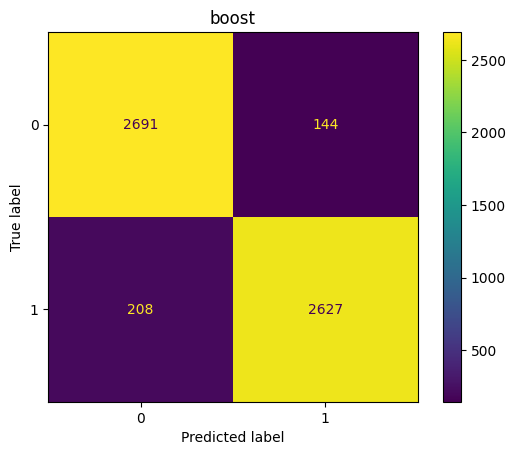

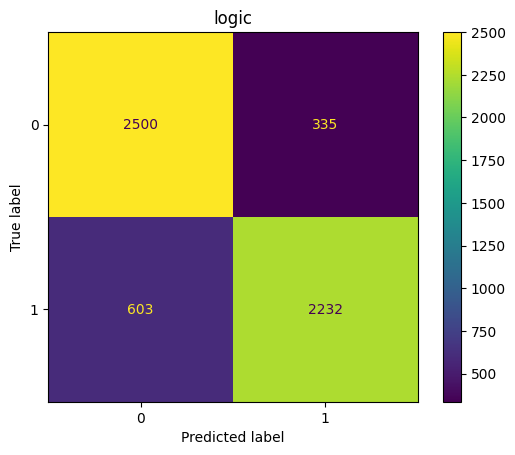

In [718]:
print('='*20,'Train','='*20)
conf_matrix_show(X_train,y_train,wt_model)
print('='*20,'Test','='*20)
conf_matrix_show(X_test,y_test,wt_model)
# print('='*20,'Real Data Test','='*20)
# conf_matrix_show(X,y,wot_model)

Gradient Boosting has lowest False Positive on Test and Train(Decision Tree and Random Forest are ignored because of overfitting). So Gradient Boosting Classifier are best model.

In [719]:
# Define best model
best_model = wt_model['boost']

## False Positive Analysis

In [720]:
data_fp = X.copy()
data_fp['predict'] = best_model.predict(X)
data_fp['actual'] = y
data_fp = data_fp.query('predict > actual')
data_fp_stats = data_fp.describe()

for i in data_fp_stats.columns[:-2]:
    print(f"Model will predict False positive if {i} data in range of {data_fp_stats.loc['25%',i]} - {data_fp_stats.loc['75%',i]}")

Model will predict False positive if aluminium data in range of 1.3875 - 3.75
Model will predict False positive if arsenic data in range of 0.01 - 0.04
Model will predict False positive if cadmium data in range of 0.002 - 0.007
Model will predict False positive if chloramine data in range of 2.5575 - 6.1075
Model will predict False positive if chromium data in range of 0.2075 - 0.6625000000000001
Model will predict False positive if silver data in range of 0.1 - 0.36


The model will predict false positive if:
- aluminium data in range of 1.205 - 3.705
- arsenic data in range of 0.02 - 0.04
- cadmium data in range of 0.002 - 0.007
- chloramine data in range of 2.535 - 6.08
- chromium data in range of 0.2 - 0.645
- silver data in range of 0.08 - 0.36

## Model Evaluation Conclusion

- In Train Test Percentage Evaluation, Gradient Boosting are good because it have > 95% precission and highest f1-score
- In Confusion Matrix Evaluation, Gradient Boosting are good because it have smallest False Positive and doesn't overfit
- The model will produce false positive if aluminium data in range of 1.205 - 3.705 and chloramine data in range of 2.535 - 6.08
- Gradient Boosting are model that'll be saved because it has smallest False Positive and it's most stable models with high precision score and f1-score


# Model Saving

In [721]:
# Feature Saving
json.dump(feature,open('feature.json','w'))
# Model Saving
joblib.dump(wt_model['boost'],'model.pkl')

['model.pkl']

# Model Inference

In [722]:
model_test = joblib.load('model.pkl')

In [723]:
column = database.columns[:-1].tolist()
data_inf = {}
for i in column:
    data_inf[i] = np.random.uniform(database[i].min(),database[i].max(),20)

pd.DataFrame(data_inf).to_csv('inference.csv',index=False)

# Requirement Listing

In [724]:
import matplotlib
import sklearn
import feature_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
req = f"""
      #python=={sys.version}
      numpy=={np.__version__}
      pandas=={pd.__version__}
      matplotlib=={matplotlib.__version__}
      seaborn=={sns.__version__}
      joblib=={joblib.__version__}
      scikit-learn=={sklearn.__version__}
      feature-engine=={feature_engine.__version__}
      """
with open('requirements.txt','w') as file:
      file.write(req)


# Conclusion

Gradient Boosting are best model because it has high precision and f1-score with lowest False Positive error.

This model has weakness that it'll produce False Positive when it meet:
- aluminium data in range of 1.205 - 3.705
- arsenic data in range of 0.02 - 0.04
- cadmium data in range of 0.002 - 0.007
- chloramine data in range of 2.535 - 6.08
- chromium data in range of 0.2 - 0.645
- silver data in range of 0.08 - 0.36